4228421


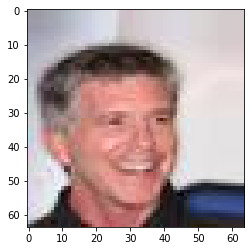

In [1]:
#Create a folder called celeba in home dir where reconstructed images will be stored
#Considered only 100000 images for training

import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as utils
import gc
import pywt
import IPython
import random
from random import sample
with __import__('importnb').Notebook():
        from wtvae_wt64 import CelebaDataset, VAE, Flatten

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
CUDA = True
BATCH_SIZE = 32
LOG_INTERVAL = 5
h_img = 64
w_img = 64
flat = h_img*w_img*3
train_losses = []

In [2]:
w=pywt.Wavelet('bior2.2')


dec_hi = torch.Tensor(w.dec_hi[::-1]).cuda() 
dec_lo = torch.Tensor(w.dec_lo[::-1]).cuda()
rec_hi = torch.Tensor(w.rec_hi).cuda()
rec_lo = torch.Tensor(w.rec_lo).cuda()

inv_filters = torch.stack([rec_lo.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_lo.unsqueeze(0)*rec_hi.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_hi.unsqueeze(1)], dim=0)

def iwt(vres, levels=1):
    h = vres.size(2)
    w = vres.size(3)
    res = vres.contiguous().view(-1,h//2,2,w//2).transpose(1,2).contiguous().view(-1,4,h//2,w//2).clone()
    print(res.shape)
    if levels>1:
        res[:,:1] = iwt(res[:,:1], levels=levels-1)
    res = torch.nn.functional.conv_transpose2d(res, Variable(inv_filters[:,None]),stride=2)
    res = res[:,:,2:-2,2:-2] #removing padding
#     print(res.shape)
    return res

def truncated_normal_(tensor, mean=0, std=0.02):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)
    
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        with torch.no_grad():
            truncated_normal_(m.weight.data, mean=0, std=0.02)
        nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, mean=0, std=0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [8]:
class LearnIWT(nn.Module):
    def __init__(self, image_channels=3, z_dim=100, device=None):
        super(LearnIWT, self).__init__()
        
        if device is None:
            self.cuda = False
            self.device = None
        else:
            self.device = device
            self.cuda = True
        
        self.z_dim = z_dim
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # X - Y Residual Encoder
        self.e1 = nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 64, 32, 32]
        weights_init(self.e1)
        self.instance_norm_e1 = nn.InstanceNorm2d(num_features=64, affine=False)

        self.e2 = nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 128, 16, 16]
        weights_init(self.e2)
        self.instance_norm_e2 = nn.InstanceNorm2d(num_features=128, affine=False)

        self.e3 = nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 256, 8, 8]
        weights_init(self.e3)
        self.instance_norm_e3 = nn.InstanceNorm2d(num_features=256, affine=False)

        self.e4 = nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 512, 4, 4]
        weights_init(self.e4)
        self.instance_norm_e4 = nn.InstanceNorm2d(num_features=512, affine=False)
        
        self.fc_enc = nn.Linear(512 * 4 * 4, 256)
        weights_init(self.fc_enc)
        
        self.fc_mean = nn.Linear(256, z_dim)
        weights_init(self.fc_mean)
        
        self.fc_var = nn.Linear(256, z_dim)
        weights_init(self.fc_var)
        
        # IWT Decoder        
#         self.d1 = nn.Linear(3 * 64 * 64, 3 * 64 * 64)
#         self.d1 = nn.Conv2d(3, 3, kernel_size=1, stride=1)
        self.d1 = nn.Conv1d(64*64, 64*64, kernel_size=1, stride=1)
        weights_init(self.d1)
        self.mu1 = nn.Linear(z_dim, 3 * 64 * 64)
        self.var1 = nn.Linear(z_dim, 3 * 64 * 64)
        self.instance_norm_d1 = nn.InstanceNorm2d(num_features=3, affine=False)
        self.iwt1 = nn.ConvTranspose2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2)
        
#         self.d2 = nn.Linear(3 * 64 * 64, 3 * 64 * 64)
#         self.d2 = nn.Conv1d(3, 3, kernel_size=1, stride=1)
#         self.d2 = nn.Conv2d(3, 3, kernel_size=1, stride=1)
#         self.d2 = nn.Conv1d(64*64, 64*64, kernel_size=1, stride=1)
#         weights_init(self.d2)

#         self.mu2 = nn.Linear(z_dim, 3 * 64 * 64)
#         self.var2 = nn.Linear(z_dim, 3 * 64 * 64)
#         self.instance_norm_d2 = nn.InstanceNorm2d(num_features=3, affine=False)
        self.iwt2 = nn.ConvTranspose2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2)
        
    
    def encode(self, x, y):
        h = self.leakyrelu(self.instance_norm_e1(self.e1(x-y)))   #[b, 64, 32, 32]
        h = self.leakyrelu(self.instance_norm_e2(self.e2(h)))     #[b, 128, 16, 16]
        h = self.leakyrelu(self.instance_norm_e3(self.e3(h)))     #[b, 256, 8, 8]
        h = self.leakyrelu(self.instance_norm_e4(self.e4(h)))     #[b, 512, 4, 4]
        h = self.leakyrelu(self.fc_enc(h.view(-1,512*4*4)))       #[b, 512 * 4 * 4]
        
        return self.fc_mean(h), F.softplus(self.fc_var(h))        #[b, z_dim]

    def reparameterize(self, mu, var):
        std = torch.sqrt(var)
        if self.cuda:
            eps = torch.FloatTensor(std.size()).normal_().to(self.device)
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu) 
    
    def decode(self, y, z):
        mu = self.mu1(z).reshape(-1, 3, 64, 64)
        var = self.var1(z).reshape(-1, 3, 64, 64)
        h = self.leakyrelu(var*self.instance_norm_d1(self.d1(y.view(y.shape[0], 64*64, 3)).reshape(-1, 3, 64, 64)) + mu) #[b, 3, 64, 64]
        h = self.leakyrelu(self.iwt1(h))                               #[b, 3, 64, 64]
        
#         mu = self.mu2(z).reshape(-1, 3, 64, 64)
#         var = self.var2(z).reshape(-1, 3, 64, 64)
#         h = self.leakyrelu(var*self.instance_norm_d2(self.d1(h.view(h.shape[0], 64*64, 3)).reshape(-1, 3, 64, 64)) + mu) #[b, 3, 64, 64]
        h = self.leakyrelu(self.iwt2(h))                               #[b, 3, 64, 64]
        
        return self.sigmoid(h)
        
        
    def forward(self, x, y):
        mu, var = self.encode(x, y)
        if self.training:
            z = self.reparameterize(mu, var)
        else:
            z = mu
        x_hat = self.decode(y, z)
        
        return x_hat, mu, var
        
        
    def loss_function(self, x, x_hat, mu, var) -> Variable:
        
        # Loss btw reconstructed img and original img
        BCE = F.mse_loss(x_hat.view(-1), x.view(-1))
        
        logvar = torch.log(var)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 0.01
#         KLD /= x.shape[0] * 3 * 64 * 64

        return BCE + KLD
        
        
        

In [39]:
# model = LearnIWT()

# print(sum(x.numel() for x in model.parameters()))

# # wt_model = VAE()
# # wt_model.load_state_dict(torch.load('/disk_c/han' + '/models/wtvae64_2wt_models/wtvae_epoch82.pth'))
# # wt_model.eval()
# # sum(x.numel() for x in wt_model.parameters())
# model

26651472


LearnIWT(
  (leakyrelu): LeakyReLU(negative_slope=0.2)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (e1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (instance_norm_e1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (e2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (instance_norm_e2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (e3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (instance_norm_e3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (e4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (instance_norm_e4): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (fc_enc): Linear(in_features=8192, out_features=256, bias=True)
  (fc_mean): Linear(in_features=256, out_features=100, bias=True)
  (fc_var): Linear(in_features=256, out_fe

In [8]:
# test = torch.zeros((32,3,32,32))
# test1 = test.contiguous().view(-1,32//2,2,32//2).transpose(1,2).contiguous().view(-1,4,32//2,32//2).clone()
# print(test1.shape)
# #torch.nn.functional.conv_transpose2d(test1.cuda(), Variable(inv_filters[:,None]),stride=2)
# t = nn.ConvTranspose2d(3, 3, kernel_size=6, stride=2)
# t1 = Variable(inv_filters[:,None])
# print(t1.shape)
# print(t.weight.shape)

# with torch.no_grad():
#     t.weight = torch.nn.Parameter(t1)

In [9]:
# Create celeba dataset
root_dir = '/disk_c/han/'
img_dir = os.path.join(root_dir, 'celeba64/')
image_files = os.listdir(img_dir)
train_dataset = CelebaDataset(img_dir, image_files, WT=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=10, shuffle=True)
sample_dataset = Subset(train_dataset, sample(range(len(train_dataset)), 8))
sample_loader = DataLoader(sample_dataset, batch_size=8, shuffle=False)

In [10]:
# Zeroing out all other patches than the first for WT image: 4D: B * C * H * W
def zero_patches(img):
    zeros = torch.zeros((img.shape[0], img.shape[1], img.shape[2], img.shape[3]))
    zeros[:,:,:16,:16] = img[:,:,:16,:16]
    
    return zeros

In [11]:
def train(epoch, model, optimizer, train_loader):
    # toggle model to train mode
    model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        
        if CUDA:
            data0 = data.to('cuda:0')
            data1 = data.clone().to('cuda:1')

        optimizer.zero_grad()
        
        # Get Y
        Y = wt_model(data1)[0]
        # Zeroing out all other patches
        Y = zero_patches(Y)
        x_hat, mu, var = iwt_model(data0, Y.to('cuda:0'))
        # Fix loss function
        loss = iwt_model.loss_function(x_hat, data0, mu, var)
        loss.backward()
        
        train_losses.append(loss.item())
        train_loss += loss
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss / len(data)))
            
            n = min(data.size(0), 8)  

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [7]:
# Loading WT model and setting to eval for inference
wt_model = VAE()
wt_model.load_state_dict(torch.load(root_dir + '/models/wtvae64_2wt_models/wtvae_epoch82.pth'))
wt_model.to('cuda:1')
wt_model.eval()
iwt_model = LearnIWT(device='cuda:0').to('cuda:0')

postfix = 'rest0_conv1d_1upsample_reuse'
sample_dir = os.path.join(root_dir, 'image_samples/')
model_dir = os.path.join(root_dir, 'models/')
if os.path.isdir('/disk_c/han/image_samples/celeba_iwtvae_{}'.format(postfix)) or os.path.isdir('/disk_c/han/models/iwtvae64_models_{}'.format(postfix)):
    raise Exception('Image sample / model directory exists!')
else:
    os.mkdir('/disk_c/han/image_samples/celeba_iwtvae_{}'.format(postfix))
    os.mkdir('/disk_c/han/models/iwtvae64_models_{}'.format(postfix))
             
train_losses = []
gc.collect()
EPOCHS = 100

optimizer = optim.Adam(iwt_model.parameters(), lr=1e-3)

for epoch in range(1, EPOCHS + 1):
    train(epoch, iwt_model, optimizer, train_loader)

    with torch.no_grad():
        iwt_model.eval()

        for data in sample_loader:
            if CUDA:
                data0 = data.to('cuda:0')
                data1 = data.to('cuda:1')
            
            z_sample = torch.randn(data.shape[0],100).to('cuda:0')
            
            Y = wt_model(data1)[0].to('cuda:0')
            mu, var = iwt_model.encode(data0, Y)
            x_hat = iwt_model.decode(Y, mu)
            x_sample = iwt_model.decode(Y, z_sample)
            
            save_image(x_hat.cpu(), sample_dir + '/celeba_iwtvae_{}/sample_recon'.format(postfix) + str(epoch) + '.png') 
            save_image(x_sample.cpu(), sample_dir + '/celeba_iwtvae_{}/sample_z'.format(postfix) + str(epoch) + '.png')
            save_image(Y.cpu(), sample_dir + '/celeba_iwtvae_{}/sample_y'.format(postfix) + str(epoch) + '.png') 
            save_image(data.cpu(), sample_dir + '/celeba_iwtvae_{}/sample'.format(postfix) + str(epoch) + '.png')  
    
    torch.save(iwt_model.state_dict(), model_dir + '/iwtvae64_models_{}/iwtvae_epoch{}.pth'.format(postfix, epoch))

Train Epoch: 1 [0/10000 (0%)]	Loss: 0.082716
Train Epoch: 1 [160/10000 (2%)]	Loss: 0.034340
Train Epoch: 1 [320/10000 (3%)]	Loss: 0.011407
Train Epoch: 1 [480/10000 (5%)]	Loss: 0.006851
Train Epoch: 1 [640/10000 (6%)]	Loss: 0.004907
Train Epoch: 1 [800/10000 (8%)]	Loss: 0.003983
Train Epoch: 1 [960/10000 (10%)]	Loss: 0.003754
Train Epoch: 1 [1120/10000 (11%)]	Loss: 0.003173
Train Epoch: 1 [1280/10000 (13%)]	Loss: 0.002804
Train Epoch: 1 [1440/10000 (14%)]	Loss: 0.002765
Train Epoch: 1 [1600/10000 (16%)]	Loss: 0.002804
Train Epoch: 1 [1760/10000 (18%)]	Loss: 0.002586
Train Epoch: 1 [1920/10000 (19%)]	Loss: 0.002735
Train Epoch: 1 [2080/10000 (21%)]	Loss: 0.002763
Train Epoch: 1 [2240/10000 (22%)]	Loss: 0.002510
Train Epoch: 1 [2400/10000 (24%)]	Loss: 0.002379
Train Epoch: 1 [2560/10000 (26%)]	Loss: 0.002530
Train Epoch: 1 [2720/10000 (27%)]	Loss: 0.002435
Train Epoch: 1 [2880/10000 (29%)]	Loss: 0.002240
Train Epoch: 1 [3040/10000 (30%)]	Loss: 0.002259
Train Epoch: 1 [3200/10000 (32%)]	L

Train Epoch: 3 [6560/10000 (65%)]	Loss: 0.001280
Train Epoch: 3 [6720/10000 (67%)]	Loss: 0.001303
Train Epoch: 3 [6880/10000 (69%)]	Loss: 0.001336
Train Epoch: 3 [7040/10000 (70%)]	Loss: 0.001342
Train Epoch: 3 [7200/10000 (72%)]	Loss: 0.001401
Train Epoch: 3 [7360/10000 (73%)]	Loss: 0.001344
Train Epoch: 3 [7520/10000 (75%)]	Loss: 0.001182
Train Epoch: 3 [7680/10000 (77%)]	Loss: 0.001104
Train Epoch: 3 [7840/10000 (78%)]	Loss: 0.001296
Train Epoch: 3 [8000/10000 (80%)]	Loss: 0.001219
Train Epoch: 3 [8160/10000 (81%)]	Loss: 0.001190
Train Epoch: 3 [8320/10000 (83%)]	Loss: 0.001229
Train Epoch: 3 [8480/10000 (85%)]	Loss: 0.001403
Train Epoch: 3 [8640/10000 (86%)]	Loss: 0.001441
Train Epoch: 3 [8800/10000 (88%)]	Loss: 0.001240
Train Epoch: 3 [8960/10000 (89%)]	Loss: 0.001277
Train Epoch: 3 [9120/10000 (91%)]	Loss: 0.001155
Train Epoch: 3 [9280/10000 (93%)]	Loss: 0.001264
Train Epoch: 3 [9440/10000 (94%)]	Loss: 0.001134
Train Epoch: 3 [9600/10000 (96%)]	Loss: 0.001362
Train Epoch: 3 [9760

Train Epoch: 6 [2880/10000 (29%)]	Loss: 0.002060
Train Epoch: 6 [3040/10000 (30%)]	Loss: 0.001623
Train Epoch: 6 [3200/10000 (32%)]	Loss: 0.001327
Train Epoch: 6 [3360/10000 (34%)]	Loss: 0.001274
Train Epoch: 6 [3520/10000 (35%)]	Loss: 0.001076
Train Epoch: 6 [3680/10000 (37%)]	Loss: 0.001122
Train Epoch: 6 [3840/10000 (38%)]	Loss: 0.001017
Train Epoch: 6 [4000/10000 (40%)]	Loss: 0.000981
Train Epoch: 6 [4160/10000 (42%)]	Loss: 0.001043
Train Epoch: 6 [4320/10000 (43%)]	Loss: 0.001058
Train Epoch: 6 [4480/10000 (45%)]	Loss: 0.001050
Train Epoch: 6 [4640/10000 (46%)]	Loss: 0.001093
Train Epoch: 6 [4800/10000 (48%)]	Loss: 0.001064
Train Epoch: 6 [4960/10000 (50%)]	Loss: 0.000933
Train Epoch: 6 [5120/10000 (51%)]	Loss: 0.000957
Train Epoch: 6 [5280/10000 (53%)]	Loss: 0.000961
Train Epoch: 6 [5440/10000 (54%)]	Loss: 0.001008
Train Epoch: 6 [5600/10000 (56%)]	Loss: 0.000995
Train Epoch: 6 [5760/10000 (58%)]	Loss: 0.000943
Train Epoch: 6 [5920/10000 (59%)]	Loss: 0.001007
Train Epoch: 6 [6080

Train Epoch: 8 [9440/10000 (94%)]	Loss: 0.000721
Train Epoch: 8 [9600/10000 (96%)]	Loss: 0.000774
Train Epoch: 8 [9760/10000 (97%)]	Loss: 0.000783
Train Epoch: 8 [9920/10000 (99%)]	Loss: 0.000783
====> Epoch: 8 Average loss: 0.0008
Train Epoch: 9 [0/10000 (0%)]	Loss: 0.000973
Train Epoch: 9 [160/10000 (2%)]	Loss: 0.000767
Train Epoch: 9 [320/10000 (3%)]	Loss: 0.000787
Train Epoch: 9 [480/10000 (5%)]	Loss: 0.000758
Train Epoch: 9 [640/10000 (6%)]	Loss: 0.000737
Train Epoch: 9 [800/10000 (8%)]	Loss: 0.000696
Train Epoch: 9 [960/10000 (10%)]	Loss: 0.000793
Train Epoch: 9 [1120/10000 (11%)]	Loss: 0.000737
Train Epoch: 9 [1280/10000 (13%)]	Loss: 0.000743
Train Epoch: 9 [1440/10000 (14%)]	Loss: 0.000742
Train Epoch: 9 [1600/10000 (16%)]	Loss: 0.000683
Train Epoch: 9 [1760/10000 (18%)]	Loss: 0.000747
Train Epoch: 9 [1920/10000 (19%)]	Loss: 0.000813
Train Epoch: 9 [2080/10000 (21%)]	Loss: 0.000784
Train Epoch: 9 [2240/10000 (22%)]	Loss: 0.000731
Train Epoch: 9 [2400/10000 (24%)]	Loss: 0.000756

Train Epoch: 11 [5440/10000 (54%)]	Loss: 0.000831
Train Epoch: 11 [5600/10000 (56%)]	Loss: 0.000682
Train Epoch: 11 [5760/10000 (58%)]	Loss: 0.000633
Train Epoch: 11 [5920/10000 (59%)]	Loss: 0.000646
Train Epoch: 11 [6080/10000 (61%)]	Loss: 0.000631
Train Epoch: 11 [6240/10000 (62%)]	Loss: 0.000639
Train Epoch: 11 [6400/10000 (64%)]	Loss: 0.000685
Train Epoch: 11 [6560/10000 (65%)]	Loss: 0.000710
Train Epoch: 11 [6720/10000 (67%)]	Loss: 0.000629
Train Epoch: 11 [6880/10000 (69%)]	Loss: 0.000623
Train Epoch: 11 [7040/10000 (70%)]	Loss: 0.000597
Train Epoch: 11 [7200/10000 (72%)]	Loss: 0.000667
Train Epoch: 11 [7360/10000 (73%)]	Loss: 0.000586
Train Epoch: 11 [7520/10000 (75%)]	Loss: 0.000667
Train Epoch: 11 [7680/10000 (77%)]	Loss: 0.000691
Train Epoch: 11 [7840/10000 (78%)]	Loss: 0.000591
Train Epoch: 11 [8000/10000 (80%)]	Loss: 0.000621
Train Epoch: 11 [8160/10000 (81%)]	Loss: 0.000633
Train Epoch: 11 [8320/10000 (83%)]	Loss: 0.000741
Train Epoch: 11 [8480/10000 (85%)]	Loss: 0.000745


Train Epoch: 14 [1280/10000 (13%)]	Loss: 0.000700
Train Epoch: 14 [1440/10000 (14%)]	Loss: 0.000667
Train Epoch: 14 [1600/10000 (16%)]	Loss: 0.000560
Train Epoch: 14 [1760/10000 (18%)]	Loss: 0.000634
Train Epoch: 14 [1920/10000 (19%)]	Loss: 0.000635
Train Epoch: 14 [2080/10000 (21%)]	Loss: 0.000546
Train Epoch: 14 [2240/10000 (22%)]	Loss: 0.000585
Train Epoch: 14 [2400/10000 (24%)]	Loss: 0.000588
Train Epoch: 14 [2560/10000 (26%)]	Loss: 0.000666
Train Epoch: 14 [2720/10000 (27%)]	Loss: 0.000555
Train Epoch: 14 [2880/10000 (29%)]	Loss: 0.000606
Train Epoch: 14 [3040/10000 (30%)]	Loss: 0.000645
Train Epoch: 14 [3200/10000 (32%)]	Loss: 0.000515
Train Epoch: 14 [3360/10000 (34%)]	Loss: 0.000536
Train Epoch: 14 [3520/10000 (35%)]	Loss: 0.000602
Train Epoch: 14 [3680/10000 (37%)]	Loss: 0.000529
Train Epoch: 14 [3840/10000 (38%)]	Loss: 0.000581
Train Epoch: 14 [4000/10000 (40%)]	Loss: 0.000521
Train Epoch: 14 [4160/10000 (42%)]	Loss: 0.000594
Train Epoch: 14 [4320/10000 (43%)]	Loss: 0.000521


Train Epoch: 16 [7200/10000 (72%)]	Loss: 0.000658
Train Epoch: 16 [7360/10000 (73%)]	Loss: 0.000552
Train Epoch: 16 [7520/10000 (75%)]	Loss: 0.000557
Train Epoch: 16 [7680/10000 (77%)]	Loss: 0.000591
Train Epoch: 16 [7840/10000 (78%)]	Loss: 0.000561
Train Epoch: 16 [8000/10000 (80%)]	Loss: 0.000508
Train Epoch: 16 [8160/10000 (81%)]	Loss: 0.000510
Train Epoch: 16 [8320/10000 (83%)]	Loss: 0.000607
Train Epoch: 16 [8480/10000 (85%)]	Loss: 0.000552
Train Epoch: 16 [8640/10000 (86%)]	Loss: 0.000575
Train Epoch: 16 [8800/10000 (88%)]	Loss: 0.000529
Train Epoch: 16 [8960/10000 (89%)]	Loss: 0.000581
Train Epoch: 16 [9120/10000 (91%)]	Loss: 0.000509
Train Epoch: 16 [9280/10000 (93%)]	Loss: 0.000541
Train Epoch: 16 [9440/10000 (94%)]	Loss: 0.000539
Train Epoch: 16 [9600/10000 (96%)]	Loss: 0.000500
Train Epoch: 16 [9760/10000 (97%)]	Loss: 0.000547
Train Epoch: 16 [9920/10000 (99%)]	Loss: 0.000517
====> Epoch: 16 Average loss: 0.0120
Train Epoch: 17 [0/10000 (0%)]	Loss: 0.000529
Train Epoch: 17 [

Train Epoch: 19 [3040/10000 (30%)]	Loss: 0.000532
Train Epoch: 19 [3200/10000 (32%)]	Loss: 0.000531
Train Epoch: 19 [3360/10000 (34%)]	Loss: 0.000480
Train Epoch: 19 [3520/10000 (35%)]	Loss: 0.000474
Train Epoch: 19 [3680/10000 (37%)]	Loss: 0.000554
Train Epoch: 19 [3840/10000 (38%)]	Loss: 0.000526
Train Epoch: 19 [4000/10000 (40%)]	Loss: 0.000517
Train Epoch: 19 [4160/10000 (42%)]	Loss: 0.000544
Train Epoch: 19 [4320/10000 (43%)]	Loss: 0.000442
Train Epoch: 19 [4480/10000 (45%)]	Loss: 0.000562
Train Epoch: 19 [4640/10000 (46%)]	Loss: 0.000521
Train Epoch: 19 [4800/10000 (48%)]	Loss: 0.000468
Train Epoch: 19 [4960/10000 (50%)]	Loss: 0.000484
Train Epoch: 19 [5120/10000 (51%)]	Loss: 0.000552
Train Epoch: 19 [5280/10000 (53%)]	Loss: 0.000525
Train Epoch: 19 [5440/10000 (54%)]	Loss: 0.000523
Train Epoch: 19 [5600/10000 (56%)]	Loss: 0.000521
Train Epoch: 19 [5760/10000 (58%)]	Loss: 0.000529
Train Epoch: 19 [5920/10000 (59%)]	Loss: 0.000482
Train Epoch: 19 [6080/10000 (61%)]	Loss: 0.000467


Train Epoch: 21 [8960/10000 (89%)]	Loss: 0.000507
Train Epoch: 21 [9120/10000 (91%)]	Loss: 0.000514
Train Epoch: 21 [9280/10000 (93%)]	Loss: 0.000499
Train Epoch: 21 [9440/10000 (94%)]	Loss: 0.000468
Train Epoch: 21 [9600/10000 (96%)]	Loss: 0.000413
Train Epoch: 21 [9760/10000 (97%)]	Loss: 0.000466
Train Epoch: 21 [9920/10000 (99%)]	Loss: 0.000479
====> Epoch: 21 Average loss: 0.0005
Train Epoch: 22 [0/10000 (0%)]	Loss: 0.000483
Train Epoch: 22 [160/10000 (2%)]	Loss: 0.000508
Train Epoch: 22 [320/10000 (3%)]	Loss: 0.000566
Train Epoch: 22 [480/10000 (5%)]	Loss: 0.000482
Train Epoch: 22 [640/10000 (6%)]	Loss: 0.000510
Train Epoch: 22 [800/10000 (8%)]	Loss: 0.000516
Train Epoch: 22 [960/10000 (10%)]	Loss: 0.000461
Train Epoch: 22 [1120/10000 (11%)]	Loss: 0.000515
Train Epoch: 22 [1280/10000 (13%)]	Loss: 0.000535
Train Epoch: 22 [1440/10000 (14%)]	Loss: 0.000486
Train Epoch: 22 [1600/10000 (16%)]	Loss: 0.000510
Train Epoch: 22 [1760/10000 (18%)]	Loss: 0.000502
Train Epoch: 22 [1920/10000 

Train Epoch: 24 [4800/10000 (48%)]	Loss: 0.000513
Train Epoch: 24 [4960/10000 (50%)]	Loss: 0.000489
Train Epoch: 24 [5120/10000 (51%)]	Loss: 0.000522
Train Epoch: 24 [5280/10000 (53%)]	Loss: 0.000488
Train Epoch: 24 [5440/10000 (54%)]	Loss: 0.000506
Train Epoch: 24 [5600/10000 (56%)]	Loss: 0.000567
Train Epoch: 24 [5760/10000 (58%)]	Loss: 0.000524
Train Epoch: 24 [5920/10000 (59%)]	Loss: 0.000516
Train Epoch: 24 [6080/10000 (61%)]	Loss: 0.000435
Train Epoch: 24 [6240/10000 (62%)]	Loss: 0.000486
Train Epoch: 24 [6400/10000 (64%)]	Loss: 0.000464
Train Epoch: 24 [6560/10000 (65%)]	Loss: 0.000497
Train Epoch: 24 [6720/10000 (67%)]	Loss: 0.000495
Train Epoch: 24 [6880/10000 (69%)]	Loss: 0.000474
Train Epoch: 24 [7040/10000 (70%)]	Loss: 0.000522
Train Epoch: 24 [7200/10000 (72%)]	Loss: 0.000518
Train Epoch: 24 [7360/10000 (73%)]	Loss: 0.000483
Train Epoch: 24 [7520/10000 (75%)]	Loss: 0.000491
Train Epoch: 24 [7680/10000 (77%)]	Loss: 0.000624
Train Epoch: 24 [7840/10000 (78%)]	Loss: 0.000663


Train Epoch: 27 [640/10000 (6%)]	Loss: 0.000631
Train Epoch: 27 [800/10000 (8%)]	Loss: 0.000529
Train Epoch: 27 [960/10000 (10%)]	Loss: 0.000522
Train Epoch: 27 [1120/10000 (11%)]	Loss: 0.000471
Train Epoch: 27 [1280/10000 (13%)]	Loss: 0.000457
Train Epoch: 27 [1440/10000 (14%)]	Loss: 0.000495
Train Epoch: 27 [1600/10000 (16%)]	Loss: 0.000485
Train Epoch: 27 [1760/10000 (18%)]	Loss: 0.000464
Train Epoch: 27 [1920/10000 (19%)]	Loss: 0.000426
Train Epoch: 27 [2080/10000 (21%)]	Loss: 0.000565
Train Epoch: 27 [2240/10000 (22%)]	Loss: 0.000441
Train Epoch: 27 [2400/10000 (24%)]	Loss: 0.000440
Train Epoch: 27 [2560/10000 (26%)]	Loss: 0.000445
Train Epoch: 27 [2720/10000 (27%)]	Loss: 0.000476
Train Epoch: 27 [2880/10000 (29%)]	Loss: 0.000416
Train Epoch: 27 [3040/10000 (30%)]	Loss: 0.000462
Train Epoch: 27 [3200/10000 (32%)]	Loss: 0.000459
Train Epoch: 27 [3360/10000 (34%)]	Loss: 0.000448
Train Epoch: 27 [3520/10000 (35%)]	Loss: 0.000507
Train Epoch: 27 [3680/10000 (37%)]	Loss: 0.000514
Train

Train Epoch: 29 [6720/10000 (67%)]	Loss: 0.000459
Train Epoch: 29 [6880/10000 (69%)]	Loss: 0.000452
Train Epoch: 29 [7040/10000 (70%)]	Loss: 0.000400
Train Epoch: 29 [7200/10000 (72%)]	Loss: 0.000548
Train Epoch: 29 [7360/10000 (73%)]	Loss: 0.000506
Train Epoch: 29 [7520/10000 (75%)]	Loss: 0.000450
Train Epoch: 29 [7680/10000 (77%)]	Loss: 0.000475
Train Epoch: 29 [7840/10000 (78%)]	Loss: 0.000448
Train Epoch: 29 [8000/10000 (80%)]	Loss: 0.000448
Train Epoch: 29 [8160/10000 (81%)]	Loss: 0.000434
Train Epoch: 29 [8320/10000 (83%)]	Loss: 0.000474
Train Epoch: 29 [8480/10000 (85%)]	Loss: 0.000469
Train Epoch: 29 [8640/10000 (86%)]	Loss: 0.000475
Train Epoch: 29 [8800/10000 (88%)]	Loss: 0.000471
Train Epoch: 29 [8960/10000 (89%)]	Loss: 0.000448
Train Epoch: 29 [9120/10000 (91%)]	Loss: 0.000429
Train Epoch: 29 [9280/10000 (93%)]	Loss: 0.000445
Train Epoch: 29 [9440/10000 (94%)]	Loss: 0.000531
Train Epoch: 29 [9600/10000 (96%)]	Loss: 0.000494
Train Epoch: 29 [9760/10000 (97%)]	Loss: 0.000434


Train Epoch: 32 [2560/10000 (26%)]	Loss: 0.000398
Train Epoch: 32 [2720/10000 (27%)]	Loss: 0.000448
Train Epoch: 32 [2880/10000 (29%)]	Loss: 0.000431
Train Epoch: 32 [3040/10000 (30%)]	Loss: 0.000467
Train Epoch: 32 [3200/10000 (32%)]	Loss: 0.000435
Train Epoch: 32 [3360/10000 (34%)]	Loss: 0.000434
Train Epoch: 32 [3520/10000 (35%)]	Loss: 0.000419
Train Epoch: 32 [3680/10000 (37%)]	Loss: 0.000457
Train Epoch: 32 [3840/10000 (38%)]	Loss: 0.000432
Train Epoch: 32 [4000/10000 (40%)]	Loss: 0.000460
Train Epoch: 32 [4160/10000 (42%)]	Loss: 0.000509
Train Epoch: 32 [4320/10000 (43%)]	Loss: 0.000377
Train Epoch: 32 [4480/10000 (45%)]	Loss: 0.000448
Train Epoch: 32 [4640/10000 (46%)]	Loss: 0.000422
Train Epoch: 32 [4800/10000 (48%)]	Loss: 0.000429
Train Epoch: 32 [4960/10000 (50%)]	Loss: 0.000427
Train Epoch: 32 [5120/10000 (51%)]	Loss: 0.000459
Train Epoch: 32 [5280/10000 (53%)]	Loss: 0.000437
Train Epoch: 32 [5440/10000 (54%)]	Loss: 0.000412
Train Epoch: 32 [5600/10000 (56%)]	Loss: 0.000399


Train Epoch: 34 [8480/10000 (85%)]	Loss: 0.000442
Train Epoch: 34 [8640/10000 (86%)]	Loss: 0.000448
Train Epoch: 34 [8800/10000 (88%)]	Loss: 0.000440
Train Epoch: 34 [8960/10000 (89%)]	Loss: 0.000434
Train Epoch: 34 [9120/10000 (91%)]	Loss: 0.000435
Train Epoch: 34 [9280/10000 (93%)]	Loss: 0.000503
Train Epoch: 34 [9440/10000 (94%)]	Loss: 0.000546
Train Epoch: 34 [9600/10000 (96%)]	Loss: 0.000505
Train Epoch: 34 [9760/10000 (97%)]	Loss: 0.000455
Train Epoch: 34 [9920/10000 (99%)]	Loss: 0.000447
====> Epoch: 34 Average loss: 0.0004
Train Epoch: 35 [0/10000 (0%)]	Loss: 0.000434
Train Epoch: 35 [160/10000 (2%)]	Loss: 0.000549
Train Epoch: 35 [320/10000 (3%)]	Loss: 0.000426
Train Epoch: 35 [480/10000 (5%)]	Loss: 0.000560
Train Epoch: 35 [640/10000 (6%)]	Loss: 0.000415
Train Epoch: 35 [800/10000 (8%)]	Loss: 0.000456
Train Epoch: 35 [960/10000 (10%)]	Loss: 0.000465
Train Epoch: 35 [1120/10000 (11%)]	Loss: 0.000432
Train Epoch: 35 [1280/10000 (13%)]	Loss: 0.000388
Train Epoch: 35 [1440/10000 

Train Epoch: 37 [4320/10000 (43%)]	Loss: 0.000383
Train Epoch: 37 [4480/10000 (45%)]	Loss: 0.000393
Train Epoch: 37 [4640/10000 (46%)]	Loss: 0.000388
Train Epoch: 37 [4800/10000 (48%)]	Loss: 0.000376
Train Epoch: 37 [4960/10000 (50%)]	Loss: 0.000412
Train Epoch: 37 [5120/10000 (51%)]	Loss: 0.000391
Train Epoch: 37 [5280/10000 (53%)]	Loss: 0.000427
Train Epoch: 37 [5440/10000 (54%)]	Loss: 0.000401
Train Epoch: 37 [5600/10000 (56%)]	Loss: 0.000426
Train Epoch: 37 [5760/10000 (58%)]	Loss: 0.000430
Train Epoch: 37 [5920/10000 (59%)]	Loss: 0.000442
Train Epoch: 37 [6080/10000 (61%)]	Loss: 0.000423
Train Epoch: 37 [6240/10000 (62%)]	Loss: 0.000398
Train Epoch: 37 [6400/10000 (64%)]	Loss: 0.000407
Train Epoch: 37 [6560/10000 (65%)]	Loss: 0.000401
Train Epoch: 37 [6720/10000 (67%)]	Loss: 0.000409
Train Epoch: 37 [6880/10000 (69%)]	Loss: 0.000458
Train Epoch: 37 [7040/10000 (70%)]	Loss: 0.000397
Train Epoch: 37 [7200/10000 (72%)]	Loss: 0.000414
Train Epoch: 37 [7360/10000 (73%)]	Loss: 0.000422


Train Epoch: 40 [160/10000 (2%)]	Loss: 0.000582
Train Epoch: 40 [320/10000 (3%)]	Loss: 0.000555
Train Epoch: 40 [480/10000 (5%)]	Loss: 0.000710
Train Epoch: 40 [640/10000 (6%)]	Loss: 0.000407
Train Epoch: 40 [800/10000 (8%)]	Loss: 0.000448
Train Epoch: 40 [960/10000 (10%)]	Loss: 0.000458
Train Epoch: 40 [1120/10000 (11%)]	Loss: 0.000422
Train Epoch: 40 [1280/10000 (13%)]	Loss: 0.000424
Train Epoch: 40 [1440/10000 (14%)]	Loss: 0.000382
Train Epoch: 40 [1600/10000 (16%)]	Loss: 0.000408
Train Epoch: 40 [1760/10000 (18%)]	Loss: 0.000379
Train Epoch: 40 [1920/10000 (19%)]	Loss: 0.000416
Train Epoch: 40 [2080/10000 (21%)]	Loss: 0.000432
Train Epoch: 40 [2240/10000 (22%)]	Loss: 0.000428
Train Epoch: 40 [2400/10000 (24%)]	Loss: 0.000361
Train Epoch: 40 [2560/10000 (26%)]	Loss: 0.000353
Train Epoch: 40 [2720/10000 (27%)]	Loss: 0.000393
Train Epoch: 40 [2880/10000 (29%)]	Loss: 0.000356
Train Epoch: 40 [3040/10000 (30%)]	Loss: 0.000401
Train Epoch: 40 [3200/10000 (32%)]	Loss: 0.000364
Train Epoch

Train Epoch: 42 [6240/10000 (62%)]	Loss: 0.000348
Train Epoch: 42 [6400/10000 (64%)]	Loss: 0.000419
Train Epoch: 42 [6560/10000 (65%)]	Loss: 0.000406
Train Epoch: 42 [6720/10000 (67%)]	Loss: 0.000361
Train Epoch: 42 [6880/10000 (69%)]	Loss: 0.000386
Train Epoch: 42 [7040/10000 (70%)]	Loss: 0.000384
Train Epoch: 42 [7200/10000 (72%)]	Loss: 0.000371
Train Epoch: 42 [7360/10000 (73%)]	Loss: 0.000417
Train Epoch: 42 [7520/10000 (75%)]	Loss: 0.000369
Train Epoch: 42 [7680/10000 (77%)]	Loss: 0.000429
Train Epoch: 42 [7840/10000 (78%)]	Loss: 0.000383
Train Epoch: 42 [8000/10000 (80%)]	Loss: 0.000426
Train Epoch: 42 [8160/10000 (81%)]	Loss: 0.000407
Train Epoch: 42 [8320/10000 (83%)]	Loss: 0.000391
Train Epoch: 42 [8480/10000 (85%)]	Loss: 0.000426
Train Epoch: 42 [8640/10000 (86%)]	Loss: 0.000449
Train Epoch: 42 [8800/10000 (88%)]	Loss: 0.000389
Train Epoch: 42 [8960/10000 (89%)]	Loss: 0.000397
Train Epoch: 42 [9120/10000 (91%)]	Loss: 0.000392
Train Epoch: 42 [9280/10000 (93%)]	Loss: 0.000391


Train Epoch: 45 [2080/10000 (21%)]	Loss: 0.000361
Train Epoch: 45 [2240/10000 (22%)]	Loss: 0.000374
Train Epoch: 45 [2400/10000 (24%)]	Loss: 0.000362
Train Epoch: 45 [2560/10000 (26%)]	Loss: 0.000350
Train Epoch: 45 [2720/10000 (27%)]	Loss: 0.000434
Train Epoch: 45 [2880/10000 (29%)]	Loss: 0.000367
Train Epoch: 45 [3040/10000 (30%)]	Loss: 0.000399
Train Epoch: 45 [3200/10000 (32%)]	Loss: 0.000368
Train Epoch: 45 [3360/10000 (34%)]	Loss: 0.000368
Train Epoch: 45 [3520/10000 (35%)]	Loss: 0.000391
Train Epoch: 45 [3680/10000 (37%)]	Loss: 0.000370
Train Epoch: 45 [3840/10000 (38%)]	Loss: 0.000415
Train Epoch: 45 [4000/10000 (40%)]	Loss: 0.000385
Train Epoch: 45 [4160/10000 (42%)]	Loss: 0.000392
Train Epoch: 45 [4320/10000 (43%)]	Loss: 0.000393
Train Epoch: 45 [4480/10000 (45%)]	Loss: 0.000391
Train Epoch: 45 [4640/10000 (46%)]	Loss: 0.000381
Train Epoch: 45 [4800/10000 (48%)]	Loss: 0.000413
Train Epoch: 45 [4960/10000 (50%)]	Loss: 0.000346
Train Epoch: 45 [5120/10000 (51%)]	Loss: 0.000441


Train Epoch: 47 [8000/10000 (80%)]	Loss: 0.000364
Train Epoch: 47 [8160/10000 (81%)]	Loss: 0.000385
Train Epoch: 47 [8320/10000 (83%)]	Loss: 0.000383
Train Epoch: 47 [8480/10000 (85%)]	Loss: 0.000406
Train Epoch: 47 [8640/10000 (86%)]	Loss: 0.000388
Train Epoch: 47 [8800/10000 (88%)]	Loss: 0.000368
Train Epoch: 47 [8960/10000 (89%)]	Loss: 0.000404
Train Epoch: 47 [9120/10000 (91%)]	Loss: 0.000382
Train Epoch: 47 [9280/10000 (93%)]	Loss: 0.000360
Train Epoch: 47 [9440/10000 (94%)]	Loss: 0.000365
Train Epoch: 47 [9600/10000 (96%)]	Loss: 0.000377
Train Epoch: 47 [9760/10000 (97%)]	Loss: 0.000442
Train Epoch: 47 [9920/10000 (99%)]	Loss: 0.000393
====> Epoch: 47 Average loss: 0.0004
Train Epoch: 48 [0/10000 (0%)]	Loss: 0.000393
Train Epoch: 48 [160/10000 (2%)]	Loss: 0.000369
Train Epoch: 48 [320/10000 (3%)]	Loss: 0.000373
Train Epoch: 48 [480/10000 (5%)]	Loss: 0.000376
Train Epoch: 48 [640/10000 (6%)]	Loss: 0.000345
Train Epoch: 48 [800/10000 (8%)]	Loss: 0.000385
Train Epoch: 48 [960/10000 

Train Epoch: 50 [3840/10000 (38%)]	Loss: 0.000364
Train Epoch: 50 [4000/10000 (40%)]	Loss: 0.000383
Train Epoch: 50 [4160/10000 (42%)]	Loss: 0.000431
Train Epoch: 50 [4320/10000 (43%)]	Loss: 0.000621
Train Epoch: 50 [4480/10000 (45%)]	Loss: 0.000521
Train Epoch: 50 [4640/10000 (46%)]	Loss: 0.000448
Train Epoch: 50 [4800/10000 (48%)]	Loss: 0.000430
Train Epoch: 50 [4960/10000 (50%)]	Loss: 0.000356
Train Epoch: 50 [5120/10000 (51%)]	Loss: 0.000350
Train Epoch: 50 [5280/10000 (53%)]	Loss: 0.000359
Train Epoch: 50 [5440/10000 (54%)]	Loss: 0.000356
Train Epoch: 50 [5600/10000 (56%)]	Loss: 0.000318
Train Epoch: 50 [5760/10000 (58%)]	Loss: 0.000354
Train Epoch: 50 [5920/10000 (59%)]	Loss: 0.000376
Train Epoch: 50 [6080/10000 (61%)]	Loss: 0.000394
Train Epoch: 50 [6240/10000 (62%)]	Loss: 0.000370
Train Epoch: 50 [6400/10000 (64%)]	Loss: 0.000359
Train Epoch: 50 [6560/10000 (65%)]	Loss: 0.000362
Train Epoch: 50 [6720/10000 (67%)]	Loss: 0.000332
Train Epoch: 50 [6880/10000 (69%)]	Loss: 0.000366


Train Epoch: 52 [9760/10000 (97%)]	Loss: 0.000381
Train Epoch: 52 [9920/10000 (99%)]	Loss: 0.000374
====> Epoch: 52 Average loss: 0.0004
Train Epoch: 53 [0/10000 (0%)]	Loss: 0.000364
Train Epoch: 53 [160/10000 (2%)]	Loss: 0.000423
Train Epoch: 53 [320/10000 (3%)]	Loss: 0.000405
Train Epoch: 53 [480/10000 (5%)]	Loss: 0.000341
Train Epoch: 53 [640/10000 (6%)]	Loss: 0.000367
Train Epoch: 53 [800/10000 (8%)]	Loss: 0.000379
Train Epoch: 53 [960/10000 (10%)]	Loss: 0.000377
Train Epoch: 53 [1120/10000 (11%)]	Loss: 0.000329
Train Epoch: 53 [1280/10000 (13%)]	Loss: 0.000369
Train Epoch: 53 [1440/10000 (14%)]	Loss: 0.000363
Train Epoch: 53 [1600/10000 (16%)]	Loss: 0.000354
Train Epoch: 53 [1760/10000 (18%)]	Loss: 0.000367
Train Epoch: 53 [1920/10000 (19%)]	Loss: 0.000354
Train Epoch: 53 [2080/10000 (21%)]	Loss: 0.000361
Train Epoch: 53 [2240/10000 (22%)]	Loss: 0.000382
Train Epoch: 53 [2400/10000 (24%)]	Loss: 0.000379
Train Epoch: 53 [2560/10000 (26%)]	Loss: 0.000413
Train Epoch: 53 [2720/10000 

Train Epoch: 55 [5600/10000 (56%)]	Loss: 0.000343
Train Epoch: 55 [5760/10000 (58%)]	Loss: 0.000358
Train Epoch: 55 [5920/10000 (59%)]	Loss: 0.000332
Train Epoch: 55 [6080/10000 (61%)]	Loss: 0.000342
Train Epoch: 55 [6240/10000 (62%)]	Loss: 0.000362
Train Epoch: 55 [6400/10000 (64%)]	Loss: 0.000375
Train Epoch: 55 [6560/10000 (65%)]	Loss: 0.000329
Train Epoch: 55 [6720/10000 (67%)]	Loss: 0.000329
Train Epoch: 55 [6880/10000 (69%)]	Loss: 0.000368
Train Epoch: 55 [7040/10000 (70%)]	Loss: 0.000388
Train Epoch: 55 [7200/10000 (72%)]	Loss: 0.000387
Train Epoch: 55 [7360/10000 (73%)]	Loss: 0.000352
Train Epoch: 55 [7520/10000 (75%)]	Loss: 0.000315
Train Epoch: 55 [7680/10000 (77%)]	Loss: 0.000374
Train Epoch: 55 [7840/10000 (78%)]	Loss: 0.000373
Train Epoch: 55 [8000/10000 (80%)]	Loss: 0.000385
Train Epoch: 55 [8160/10000 (81%)]	Loss: 0.000343
Train Epoch: 55 [8320/10000 (83%)]	Loss: 0.000378
Train Epoch: 55 [8480/10000 (85%)]	Loss: 0.000345
Train Epoch: 55 [8640/10000 (86%)]	Loss: 0.000379


Train Epoch: 58 [1440/10000 (14%)]	Loss: 0.000339
Train Epoch: 58 [1600/10000 (16%)]	Loss: 0.000339
Train Epoch: 58 [1760/10000 (18%)]	Loss: 0.000307
Train Epoch: 58 [1920/10000 (19%)]	Loss: 0.000383
Train Epoch: 58 [2080/10000 (21%)]	Loss: 0.000318
Train Epoch: 58 [2240/10000 (22%)]	Loss: 0.000366
Train Epoch: 58 [2400/10000 (24%)]	Loss: 0.000294
Train Epoch: 58 [2560/10000 (26%)]	Loss: 0.000338
Train Epoch: 58 [2720/10000 (27%)]	Loss: 0.000337
Train Epoch: 58 [2880/10000 (29%)]	Loss: 0.000347
Train Epoch: 58 [3040/10000 (30%)]	Loss: 0.000338
Train Epoch: 58 [3200/10000 (32%)]	Loss: 0.000370
Train Epoch: 58 [3360/10000 (34%)]	Loss: 0.000381
Train Epoch: 58 [3520/10000 (35%)]	Loss: 0.000373
Train Epoch: 58 [3680/10000 (37%)]	Loss: 0.000393
Train Epoch: 58 [3840/10000 (38%)]	Loss: 0.000368
Train Epoch: 58 [4000/10000 (40%)]	Loss: 0.000301
Train Epoch: 58 [4160/10000 (42%)]	Loss: 0.000366
Train Epoch: 58 [4320/10000 (43%)]	Loss: 0.000362
Train Epoch: 58 [4480/10000 (45%)]	Loss: 0.000322


Train Epoch: 60 [7360/10000 (73%)]	Loss: 0.000329
Train Epoch: 60 [7520/10000 (75%)]	Loss: 0.000378
Train Epoch: 60 [7680/10000 (77%)]	Loss: 0.000374
Train Epoch: 60 [7840/10000 (78%)]	Loss: 0.000396
Train Epoch: 60 [8000/10000 (80%)]	Loss: 0.000341
Train Epoch: 60 [8160/10000 (81%)]	Loss: 0.000348
Train Epoch: 60 [8320/10000 (83%)]	Loss: 0.000308
Train Epoch: 60 [8480/10000 (85%)]	Loss: 0.000373
Train Epoch: 60 [8640/10000 (86%)]	Loss: 0.000335
Train Epoch: 60 [8800/10000 (88%)]	Loss: 0.000333
Train Epoch: 60 [8960/10000 (89%)]	Loss: 0.000337
Train Epoch: 60 [9120/10000 (91%)]	Loss: 0.000361
Train Epoch: 60 [9280/10000 (93%)]	Loss: 0.000388
Train Epoch: 60 [9440/10000 (94%)]	Loss: 0.000404
Train Epoch: 60 [9600/10000 (96%)]	Loss: 0.000357
Train Epoch: 60 [9760/10000 (97%)]	Loss: 0.000397
Train Epoch: 60 [9920/10000 (99%)]	Loss: 0.000340
====> Epoch: 60 Average loss: 0.0003
Train Epoch: 61 [0/10000 (0%)]	Loss: 0.000360
Train Epoch: 61 [160/10000 (2%)]	Loss: 0.000626
Train Epoch: 61 [32

Train Epoch: 63 [3200/10000 (32%)]	Loss: 0.000310
Train Epoch: 63 [3360/10000 (34%)]	Loss: 0.000307
Train Epoch: 63 [3520/10000 (35%)]	Loss: 0.000319
Train Epoch: 63 [3680/10000 (37%)]	Loss: 0.000320
Train Epoch: 63 [3840/10000 (38%)]	Loss: 0.000321
Train Epoch: 63 [4000/10000 (40%)]	Loss: 0.000293
Train Epoch: 63 [4160/10000 (42%)]	Loss: 0.000286
Train Epoch: 63 [4320/10000 (43%)]	Loss: 0.000333
Train Epoch: 63 [4480/10000 (45%)]	Loss: 0.000295
Train Epoch: 63 [4640/10000 (46%)]	Loss: 0.000331
Train Epoch: 63 [4800/10000 (48%)]	Loss: 0.000315
Train Epoch: 63 [4960/10000 (50%)]	Loss: 0.000328
Train Epoch: 63 [5120/10000 (51%)]	Loss: 0.000290
Train Epoch: 63 [5280/10000 (53%)]	Loss: 0.000317
Train Epoch: 63 [5440/10000 (54%)]	Loss: 0.000297
Train Epoch: 63 [5600/10000 (56%)]	Loss: 0.000329
Train Epoch: 63 [5760/10000 (58%)]	Loss: 0.000333
Train Epoch: 63 [5920/10000 (59%)]	Loss: 0.000311
Train Epoch: 63 [6080/10000 (61%)]	Loss: 0.000300
Train Epoch: 63 [6240/10000 (62%)]	Loss: 0.000339


Train Epoch: 65 [9120/10000 (91%)]	Loss: 0.000353
Train Epoch: 65 [9280/10000 (93%)]	Loss: 0.000397
Train Epoch: 65 [9440/10000 (94%)]	Loss: 0.000374
Train Epoch: 65 [9600/10000 (96%)]	Loss: 0.000353
Train Epoch: 65 [9760/10000 (97%)]	Loss: 0.000299
Train Epoch: 65 [9920/10000 (99%)]	Loss: 0.000315
====> Epoch: 65 Average loss: 0.0004
Train Epoch: 66 [0/10000 (0%)]	Loss: 0.000331
Train Epoch: 66 [160/10000 (2%)]	Loss: 0.000355
Train Epoch: 66 [320/10000 (3%)]	Loss: 0.000321
Train Epoch: 66 [480/10000 (5%)]	Loss: 0.000318
Train Epoch: 66 [640/10000 (6%)]	Loss: 0.000293
Train Epoch: 66 [800/10000 (8%)]	Loss: 0.000331
Train Epoch: 66 [960/10000 (10%)]	Loss: 0.000312
Train Epoch: 66 [1120/10000 (11%)]	Loss: 0.000298
Train Epoch: 66 [1280/10000 (13%)]	Loss: 0.000321
Train Epoch: 66 [1440/10000 (14%)]	Loss: 0.000317
Train Epoch: 66 [1600/10000 (16%)]	Loss: 0.000276
Train Epoch: 66 [1760/10000 (18%)]	Loss: 0.000284
Train Epoch: 66 [1920/10000 (19%)]	Loss: 0.000303
Train Epoch: 66 [2080/10000 

Train Epoch: 68 [4960/10000 (50%)]	Loss: 0.000292
Train Epoch: 68 [5120/10000 (51%)]	Loss: 0.000324
Train Epoch: 68 [5280/10000 (53%)]	Loss: 0.000295
Train Epoch: 68 [5440/10000 (54%)]	Loss: 0.000315
Train Epoch: 68 [5600/10000 (56%)]	Loss: 0.000316
Train Epoch: 68 [5760/10000 (58%)]	Loss: 0.000343
Train Epoch: 68 [5920/10000 (59%)]	Loss: 0.000288
Train Epoch: 68 [6080/10000 (61%)]	Loss: 0.000304
Train Epoch: 68 [6240/10000 (62%)]	Loss: 0.000302
Train Epoch: 68 [6400/10000 (64%)]	Loss: 0.000311
Train Epoch: 68 [6560/10000 (65%)]	Loss: 0.000313
Train Epoch: 68 [6720/10000 (67%)]	Loss: 0.000301
Train Epoch: 68 [6880/10000 (69%)]	Loss: 0.000310
Train Epoch: 68 [7040/10000 (70%)]	Loss: 0.000295
Train Epoch: 68 [7200/10000 (72%)]	Loss: 0.000290
Train Epoch: 68 [7360/10000 (73%)]	Loss: 0.000325
Train Epoch: 68 [7520/10000 (75%)]	Loss: 0.000307
Train Epoch: 68 [7680/10000 (77%)]	Loss: 0.000299
Train Epoch: 68 [7840/10000 (78%)]	Loss: 0.000311
Train Epoch: 68 [8000/10000 (80%)]	Loss: 0.000322


Train Epoch: 71 [800/10000 (8%)]	Loss: 0.000258
Train Epoch: 71 [960/10000 (10%)]	Loss: 0.000289
Train Epoch: 71 [1120/10000 (11%)]	Loss: 0.000291
Train Epoch: 71 [1280/10000 (13%)]	Loss: 0.000269
Train Epoch: 71 [1440/10000 (14%)]	Loss: 0.000294
Train Epoch: 71 [1600/10000 (16%)]	Loss: 0.000268
Train Epoch: 71 [1760/10000 (18%)]	Loss: 0.000290
Train Epoch: 71 [1920/10000 (19%)]	Loss: 0.000280
Train Epoch: 71 [2080/10000 (21%)]	Loss: 0.000309
Train Epoch: 71 [2240/10000 (22%)]	Loss: 0.000265
Train Epoch: 71 [2400/10000 (24%)]	Loss: 0.000262
Train Epoch: 71 [2560/10000 (26%)]	Loss: 0.000274
Train Epoch: 71 [2720/10000 (27%)]	Loss: 0.000306
Train Epoch: 71 [2880/10000 (29%)]	Loss: 0.000302
Train Epoch: 71 [3040/10000 (30%)]	Loss: 0.000336
Train Epoch: 71 [3200/10000 (32%)]	Loss: 0.000276
Train Epoch: 71 [3360/10000 (34%)]	Loss: 0.000314
Train Epoch: 71 [3520/10000 (35%)]	Loss: 0.000313
Train Epoch: 71 [3680/10000 (37%)]	Loss: 0.000290
Train Epoch: 71 [3840/10000 (38%)]	Loss: 0.000287
Tra

Train Epoch: 73 [6880/10000 (69%)]	Loss: 0.000303
Train Epoch: 73 [7040/10000 (70%)]	Loss: 0.000313
Train Epoch: 73 [7200/10000 (72%)]	Loss: 0.000309
Train Epoch: 73 [7360/10000 (73%)]	Loss: 0.000307
Train Epoch: 73 [7520/10000 (75%)]	Loss: 0.000330
Train Epoch: 73 [7680/10000 (77%)]	Loss: 0.000366
Train Epoch: 73 [7840/10000 (78%)]	Loss: 0.000396
Train Epoch: 73 [8000/10000 (80%)]	Loss: 0.000431
Train Epoch: 73 [8160/10000 (81%)]	Loss: 0.000404
Train Epoch: 73 [8320/10000 (83%)]	Loss: 0.000288
Train Epoch: 73 [8480/10000 (85%)]	Loss: 0.000305
Train Epoch: 73 [8640/10000 (86%)]	Loss: 0.000283
Train Epoch: 73 [8800/10000 (88%)]	Loss: 0.000279
Train Epoch: 73 [8960/10000 (89%)]	Loss: 0.000286
Train Epoch: 73 [9120/10000 (91%)]	Loss: 0.000307
Train Epoch: 73 [9280/10000 (93%)]	Loss: 0.000306
Train Epoch: 73 [9440/10000 (94%)]	Loss: 0.000281
Train Epoch: 73 [9600/10000 (96%)]	Loss: 0.000309
Train Epoch: 73 [9760/10000 (97%)]	Loss: 0.000306
Train Epoch: 73 [9920/10000 (99%)]	Loss: 0.000352


Train Epoch: 76 [2720/10000 (27%)]	Loss: 0.000277
Train Epoch: 76 [2880/10000 (29%)]	Loss: 0.000251
Train Epoch: 76 [3040/10000 (30%)]	Loss: 0.000302
Train Epoch: 76 [3200/10000 (32%)]	Loss: 0.000299
Train Epoch: 76 [3360/10000 (34%)]	Loss: 0.000262
Train Epoch: 76 [3520/10000 (35%)]	Loss: 0.000284
Train Epoch: 76 [3680/10000 (37%)]	Loss: 0.000272
Train Epoch: 76 [3840/10000 (38%)]	Loss: 0.000300
Train Epoch: 76 [4000/10000 (40%)]	Loss: 0.000269
Train Epoch: 76 [4160/10000 (42%)]	Loss: 0.000291
Train Epoch: 76 [4320/10000 (43%)]	Loss: 0.000266
Train Epoch: 76 [4480/10000 (45%)]	Loss: 0.000280
Train Epoch: 76 [4640/10000 (46%)]	Loss: 0.000275
Train Epoch: 76 [4800/10000 (48%)]	Loss: 0.000283
Train Epoch: 76 [4960/10000 (50%)]	Loss: 0.000286
Train Epoch: 76 [5120/10000 (51%)]	Loss: 0.000252
Train Epoch: 76 [5280/10000 (53%)]	Loss: 0.000277
Train Epoch: 76 [5440/10000 (54%)]	Loss: 0.000262
Train Epoch: 76 [5600/10000 (56%)]	Loss: 0.000265
Train Epoch: 76 [5760/10000 (58%)]	Loss: 0.000270


Train Epoch: 78 [8640/10000 (86%)]	Loss: 0.000273
Train Epoch: 78 [8800/10000 (88%)]	Loss: 0.000246
Train Epoch: 78 [8960/10000 (89%)]	Loss: 0.000294
Train Epoch: 78 [9120/10000 (91%)]	Loss: 0.000280
Train Epoch: 78 [9280/10000 (93%)]	Loss: 0.000287
Train Epoch: 78 [9440/10000 (94%)]	Loss: 0.000301
Train Epoch: 78 [9600/10000 (96%)]	Loss: 0.000276
Train Epoch: 78 [9760/10000 (97%)]	Loss: 0.000290
Train Epoch: 78 [9920/10000 (99%)]	Loss: 0.000308
====> Epoch: 78 Average loss: 0.0003
Train Epoch: 79 [0/10000 (0%)]	Loss: 0.000293
Train Epoch: 79 [160/10000 (2%)]	Loss: 0.003303
Train Epoch: 79 [320/10000 (3%)]	Loss: 0.002359
Train Epoch: 79 [480/10000 (5%)]	Loss: 0.012726
Train Epoch: 79 [640/10000 (6%)]	Loss: 0.014827
Train Epoch: 79 [800/10000 (8%)]	Loss: 0.011721
Train Epoch: 79 [960/10000 (10%)]	Loss: 0.014443
Train Epoch: 79 [1120/10000 (11%)]	Loss: 0.031204
Train Epoch: 79 [1280/10000 (13%)]	Loss: 0.039569
Train Epoch: 79 [1440/10000 (14%)]	Loss: 0.071571
Train Epoch: 79 [1600/10000 

Train Epoch: 81 [4480/10000 (45%)]	Loss: 0.000271
Train Epoch: 81 [4640/10000 (46%)]	Loss: 0.000252
Train Epoch: 81 [4800/10000 (48%)]	Loss: 0.000252
Train Epoch: 81 [4960/10000 (50%)]	Loss: 0.000261
Train Epoch: 81 [5120/10000 (51%)]	Loss: 0.000253
Train Epoch: 81 [5280/10000 (53%)]	Loss: 0.000258
Train Epoch: 81 [5440/10000 (54%)]	Loss: 0.000275
Train Epoch: 81 [5600/10000 (56%)]	Loss: 0.000281
Train Epoch: 81 [5760/10000 (58%)]	Loss: 0.000281
Train Epoch: 81 [5920/10000 (59%)]	Loss: 0.000260
Train Epoch: 81 [6080/10000 (61%)]	Loss: 0.000266
Train Epoch: 81 [6240/10000 (62%)]	Loss: 0.000284
Train Epoch: 81 [6400/10000 (64%)]	Loss: 0.000279
Train Epoch: 81 [6560/10000 (65%)]	Loss: 0.000275
Train Epoch: 81 [6720/10000 (67%)]	Loss: 0.000307
Train Epoch: 81 [6880/10000 (69%)]	Loss: 0.000246
Train Epoch: 81 [7040/10000 (70%)]	Loss: 0.000251
Train Epoch: 81 [7200/10000 (72%)]	Loss: 0.000270
Train Epoch: 81 [7360/10000 (73%)]	Loss: 0.000266
Train Epoch: 81 [7520/10000 (75%)]	Loss: 0.000249


Train Epoch: 84 [320/10000 (3%)]	Loss: 0.000287
Train Epoch: 84 [480/10000 (5%)]	Loss: 0.000269
Train Epoch: 84 [640/10000 (6%)]	Loss: 0.000253
Train Epoch: 84 [800/10000 (8%)]	Loss: 0.000285
Train Epoch: 84 [960/10000 (10%)]	Loss: 0.000263
Train Epoch: 84 [1120/10000 (11%)]	Loss: 0.000248
Train Epoch: 84 [1280/10000 (13%)]	Loss: 0.000233
Train Epoch: 84 [1440/10000 (14%)]	Loss: 0.000264
Train Epoch: 84 [1600/10000 (16%)]	Loss: 0.000263
Train Epoch: 84 [1760/10000 (18%)]	Loss: 0.000251
Train Epoch: 84 [1920/10000 (19%)]	Loss: 0.000260
Train Epoch: 84 [2080/10000 (21%)]	Loss: 0.000261
Train Epoch: 84 [2240/10000 (22%)]	Loss: 0.000258
Train Epoch: 84 [2400/10000 (24%)]	Loss: 0.000267
Train Epoch: 84 [2560/10000 (26%)]	Loss: 0.000263
Train Epoch: 84 [2720/10000 (27%)]	Loss: 0.000267
Train Epoch: 84 [2880/10000 (29%)]	Loss: 0.000256
Train Epoch: 84 [3040/10000 (30%)]	Loss: 0.000280
Train Epoch: 84 [3200/10000 (32%)]	Loss: 0.000256
Train Epoch: 84 [3360/10000 (34%)]	Loss: 0.000278
Train Epo

Train Epoch: 86 [6400/10000 (64%)]	Loss: 0.000295
Train Epoch: 86 [6560/10000 (65%)]	Loss: 0.000265
Train Epoch: 86 [6720/10000 (67%)]	Loss: 0.000288
Train Epoch: 86 [6880/10000 (69%)]	Loss: 0.000253
Train Epoch: 86 [7040/10000 (70%)]	Loss: 0.000257
Train Epoch: 86 [7200/10000 (72%)]	Loss: 0.000259
Train Epoch: 86 [7360/10000 (73%)]	Loss: 0.000264
Train Epoch: 86 [7520/10000 (75%)]	Loss: 0.000241
Train Epoch: 86 [7680/10000 (77%)]	Loss: 0.000248
Train Epoch: 86 [7840/10000 (78%)]	Loss: 0.000252
Train Epoch: 86 [8000/10000 (80%)]	Loss: 0.000313
Train Epoch: 86 [8160/10000 (81%)]	Loss: 0.000288
Train Epoch: 86 [8320/10000 (83%)]	Loss: 0.000223
Train Epoch: 86 [8480/10000 (85%)]	Loss: 0.000242
Train Epoch: 86 [8640/10000 (86%)]	Loss: 0.000257
Train Epoch: 86 [8800/10000 (88%)]	Loss: 0.000250
Train Epoch: 86 [8960/10000 (89%)]	Loss: 0.000254
Train Epoch: 86 [9120/10000 (91%)]	Loss: 0.000259
Train Epoch: 86 [9280/10000 (93%)]	Loss: 0.000256
Train Epoch: 86 [9440/10000 (94%)]	Loss: 0.000266


Train Epoch: 89 [2240/10000 (22%)]	Loss: 0.001395
Train Epoch: 89 [2400/10000 (24%)]	Loss: 0.000979
Train Epoch: 89 [2560/10000 (26%)]	Loss: 0.000882
Train Epoch: 89 [2720/10000 (27%)]	Loss: 0.000675
Train Epoch: 89 [2880/10000 (29%)]	Loss: 0.000486
Train Epoch: 89 [3040/10000 (30%)]	Loss: 0.000391
Train Epoch: 89 [3200/10000 (32%)]	Loss: 0.000338
Train Epoch: 89 [3360/10000 (34%)]	Loss: 0.000312
Train Epoch: 89 [3520/10000 (35%)]	Loss: 0.000284
Train Epoch: 89 [3680/10000 (37%)]	Loss: 0.000273
Train Epoch: 89 [3840/10000 (38%)]	Loss: 0.000252
Train Epoch: 89 [4000/10000 (40%)]	Loss: 0.000249
Train Epoch: 89 [4160/10000 (42%)]	Loss: 0.000268
Train Epoch: 89 [4320/10000 (43%)]	Loss: 0.000265
Train Epoch: 89 [4480/10000 (45%)]	Loss: 0.000234
Train Epoch: 89 [4640/10000 (46%)]	Loss: 0.000277
Train Epoch: 89 [4800/10000 (48%)]	Loss: 0.000235
Train Epoch: 89 [4960/10000 (50%)]	Loss: 0.000245
Train Epoch: 89 [5120/10000 (51%)]	Loss: 0.000271
Train Epoch: 89 [5280/10000 (53%)]	Loss: 0.000246


Train Epoch: 91 [8160/10000 (81%)]	Loss: 0.000251
Train Epoch: 91 [8320/10000 (83%)]	Loss: 0.000228
Train Epoch: 91 [8480/10000 (85%)]	Loss: 0.000240
Train Epoch: 91 [8640/10000 (86%)]	Loss: 0.000249
Train Epoch: 91 [8800/10000 (88%)]	Loss: 0.000238
Train Epoch: 91 [8960/10000 (89%)]	Loss: 0.000248
Train Epoch: 91 [9120/10000 (91%)]	Loss: 0.000241
Train Epoch: 91 [9280/10000 (93%)]	Loss: 0.000242
Train Epoch: 91 [9440/10000 (94%)]	Loss: 0.000310
Train Epoch: 91 [9600/10000 (96%)]	Loss: 0.000413
Train Epoch: 91 [9760/10000 (97%)]	Loss: 0.000331
Train Epoch: 91 [9920/10000 (99%)]	Loss: 0.000268
====> Epoch: 91 Average loss: 0.0003
Train Epoch: 92 [0/10000 (0%)]	Loss: 0.000273
Train Epoch: 92 [160/10000 (2%)]	Loss: 0.000814
Train Epoch: 92 [320/10000 (3%)]	Loss: 0.000890
Train Epoch: 92 [480/10000 (5%)]	Loss: 0.002246
Train Epoch: 92 [640/10000 (6%)]	Loss: 0.003068
Train Epoch: 92 [800/10000 (8%)]	Loss: 0.007739
Train Epoch: 92 [960/10000 (10%)]	Loss: 0.016920
Train Epoch: 92 [1120/10000 

Train Epoch: 94 [4000/10000 (40%)]	Loss: 0.000240
Train Epoch: 94 [4160/10000 (42%)]	Loss: 0.000232
Train Epoch: 94 [4320/10000 (43%)]	Loss: 0.000268
Train Epoch: 94 [4480/10000 (45%)]	Loss: 0.000259
Train Epoch: 94 [4640/10000 (46%)]	Loss: 0.000255
Train Epoch: 94 [4800/10000 (48%)]	Loss: 0.000254
Train Epoch: 94 [4960/10000 (50%)]	Loss: 0.000228
Train Epoch: 94 [5120/10000 (51%)]	Loss: 0.000251
Train Epoch: 94 [5280/10000 (53%)]	Loss: 0.000214
Train Epoch: 94 [5440/10000 (54%)]	Loss: 0.000242
Train Epoch: 94 [5600/10000 (56%)]	Loss: 0.000243
Train Epoch: 94 [5760/10000 (58%)]	Loss: 0.000215
Train Epoch: 94 [5920/10000 (59%)]	Loss: 0.000238
Train Epoch: 94 [6080/10000 (61%)]	Loss: 0.000266
Train Epoch: 94 [6240/10000 (62%)]	Loss: 0.000222
Train Epoch: 94 [6400/10000 (64%)]	Loss: 0.000261
Train Epoch: 94 [6560/10000 (65%)]	Loss: 0.000231
Train Epoch: 94 [6720/10000 (67%)]	Loss: 0.000235
Train Epoch: 94 [6880/10000 (69%)]	Loss: 0.000235
Train Epoch: 94 [7040/10000 (70%)]	Loss: 0.000224


====> Epoch: 96 Average loss: 0.0002
Train Epoch: 97 [0/10000 (0%)]	Loss: 0.000237
Train Epoch: 97 [160/10000 (2%)]	Loss: 0.000228
Train Epoch: 97 [320/10000 (3%)]	Loss: 0.000254
Train Epoch: 97 [480/10000 (5%)]	Loss: 0.000262
Train Epoch: 97 [640/10000 (6%)]	Loss: 0.000241
Train Epoch: 97 [800/10000 (8%)]	Loss: 0.000222
Train Epoch: 97 [960/10000 (10%)]	Loss: 0.000230
Train Epoch: 97 [1120/10000 (11%)]	Loss: 0.000256
Train Epoch: 97 [1280/10000 (13%)]	Loss: 0.000216
Train Epoch: 97 [1440/10000 (14%)]	Loss: 0.000251
Train Epoch: 97 [1600/10000 (16%)]	Loss: 0.000254
Train Epoch: 97 [1760/10000 (18%)]	Loss: 0.000235
Train Epoch: 97 [1920/10000 (19%)]	Loss: 0.000283
Train Epoch: 97 [2080/10000 (21%)]	Loss: 0.000248
Train Epoch: 97 [2240/10000 (22%)]	Loss: 0.000201
Train Epoch: 97 [2400/10000 (24%)]	Loss: 0.000219
Train Epoch: 97 [2560/10000 (26%)]	Loss: 0.000254
Train Epoch: 97 [2720/10000 (27%)]	Loss: 0.000223
Train Epoch: 97 [2880/10000 (29%)]	Loss: 0.000229
Train Epoch: 97 [3040/10000 

Train Epoch: 99 [5920/10000 (59%)]	Loss: 0.000214
Train Epoch: 99 [6080/10000 (61%)]	Loss: 0.000266
Train Epoch: 99 [6240/10000 (62%)]	Loss: 0.000224
Train Epoch: 99 [6400/10000 (64%)]	Loss: 0.000245
Train Epoch: 99 [6560/10000 (65%)]	Loss: 0.000252
Train Epoch: 99 [6720/10000 (67%)]	Loss: 0.000225
Train Epoch: 99 [6880/10000 (69%)]	Loss: 0.000235
Train Epoch: 99 [7040/10000 (70%)]	Loss: 0.000251
Train Epoch: 99 [7200/10000 (72%)]	Loss: 0.000232
Train Epoch: 99 [7360/10000 (73%)]	Loss: 0.000240
Train Epoch: 99 [7520/10000 (75%)]	Loss: 0.000251
Train Epoch: 99 [7680/10000 (77%)]	Loss: 0.000216
Train Epoch: 99 [7840/10000 (78%)]	Loss: 0.000213
Train Epoch: 99 [8000/10000 (80%)]	Loss: 0.000240
Train Epoch: 99 [8160/10000 (81%)]	Loss: 0.000233
Train Epoch: 99 [8320/10000 (83%)]	Loss: 0.000271
Train Epoch: 99 [8480/10000 (85%)]	Loss: 0.000322
Train Epoch: 99 [8640/10000 (86%)]	Loss: 0.000371
Train Epoch: 99 [8800/10000 (88%)]	Loss: 0.000266
Train Epoch: 99 [8960/10000 (89%)]	Loss: 0.000247


In [ ]:
plt.plot(train_losses)
plt.show()

In [10]:
os.path.join(root_dir, '/models')

'/models'

In [11]:
root_dir

'/disk_c/han/'